In [1]:
%load_ext autoreload
%autoreload 2

# 🍕 Slice Discovery with Clever Meerkat

In this notebook 

In [22]:
from meerkat.clever.embed import embed
import numpy as np
import pandas as pd
import torch 

In [3]:
import dcbench

In [4]:
sd = dcbench.tasks["slice_discovery"]

In [149]:
sd.problems.df[:10]

,alpha,dataset,n_pred_slices,slice_category,slice_names,target_name
p_72776,0.2,celeba,5,correlation,"[wearing_lipstick=0_young=1, wearing_lipstick=...",wearing_lipstick
p_72793,0.6,celeba,5,correlation,"[wearing_necklace=0_black_hair=1, wearing_neck...",wearing_necklace
p_72800,0.2,celeba,5,correlation,"[wearing_necklace=0_brown_hair=1, wearing_neck...",wearing_necklace
p_72799,0.6,celeba,5,correlation,"[wearing_necklace=0_smiling=1, wearing_necklac...",wearing_necklace
p_72802,0.2,celeba,5,correlation,"[wearing_necklace=0_wearing_lipstick=1, wearin...",wearing_necklace
p_72831,0.6,celeba,5,correlation,"[wearing_necklace=0_young=1, wearing_necklace=...",wearing_necklace
p_72837,0.2,celeba,5,correlation,"[wearing_necktie=0_black_hair=1, wearing_neckt...",wearing_necktie
p_72838,0.6,celeba,5,correlation,"[wearing_necktie=0_eyeglasses=1, wearing_neckt...",wearing_necktie
p_72840,0.2,celeba,5,correlation,"[wearing_necktie=0_mustache=1, wearing_necktie...",wearing_necktie
p_72857,0.6,celeba,5,correlation,"[wearing_necktie=0_no_beard=1, wearing_necktie...",wearing_necktie


In [150]:
problem = sd.problems["p_72838"]

In [151]:
dp = problem["val_predictions"][["probs", "id", "target"]].merge(problem["base_dataset"], on="id")

/home/users/eyuboglu/code/clever-meerkat/meerkat/ops/merge.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  merged_df = merged_df[set(left_on) & set(right_on)]


In [152]:
dp = embed(
    data=dp,
    input_col="image",
    encoder="clip",
    device=0,
    num_workers=20
)

  0%|          | 0/23 [00:00<?, ?it/s]

In [153]:
dp["pred"] = dp["probs"].argmax(-1).numpy()
dp["correct"] = (dp["pred"] == dp["target"])

In [174]:
groupby = dp.groupby(
    [embed("image"), "target", "probs"],
    n_groups=15
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [175]:
group_dp = groupby[["clip(image)", "target", "pred", "correct"]].mean()
group_dp

clip(image)-target-probs


,clip(image)-target-probs (NumpyArrayColumn),clip(image) (NumpyArrayColumn),target (PandasSeriesColumn),pred (PandasSeriesColumn),correct (PandasSeriesColumn)
0,0,"np.ndarray(shape=(512,))",1.000000,0.117647,0.117647
1,1,"np.ndarray(shape=(512,))",1.000000,0.170732,0.170732
2,2,"np.ndarray(shape=(512,))",1.000000,0.375000,0.375000
3,3,"np.ndarray(shape=(512,))",1.000000,0.352941,0.352941
4,4,"np.ndarray(shape=(512,))",1.000000,0.846154,0.846154
5,5,"np.ndarray(shape=(512,))",0.000000,0.067797,0.932203
6,6,"np.ndarray(shape=(512,))",0.000000,0.037344,0.962656
7,7,"np.ndarray(shape=(512,))",0.000000,0.008772,0.991228
8,8,"np.ndarray(shape=(512,))",0.870968,1.000000,0.870968
9,9,"np.ndarray(shape=(512,))",0.000000,0.016043,0.983957


In [157]:
from domino import generate_candidate_descriptions

In [166]:
text_dp = generate_candidate_descriptions(
    templates=[
        "a photo of a person [MASK].",
        "a photo of a [MASK] person.",
        "a photo of a {} [MASK] person.",
        "a photo of a [MASK] {} person.",
        "a photo of a [MASK] person {}.",
        "a photo of a person {} [MASK].",
        "a photo of person [MASK].",
        "a photo of [MASK] person.",
        "a photo of {} [MASK] person.",
        "a photo of [MASK] {} person.",
        "a photo of [MASK] person {}.",
        "a photo of person {} [MASK].",
    ], 
    num_candidates=1_000
)

[nltk_data] Downloading package words to
[nltk_data]     /home/users/eyuboglu/nltk_data...
[nltk_data]   Package words is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/625 [00:00<?, ?it/s]

In [167]:
text_dp = embed(
    data=text_dp,
    input_col="output_phrase",
    encoder="clip",
    device=0,
    num_workers=20
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [185]:
print(target_dp["clip(image)"][0][:10])
print(dp["clip(image)"].lz[dp["target"] == 0].data.mean(axis=0)[:10])

[ 0.29985365 -0.07020673 -0.1470911   0.09888401  0.15404318 -0.3805342
 -0.02233123 -0.11351994  0.21844128 -0.03572082]
[ 0.2998  -0.0709  -0.146    0.09827  0.1537  -0.381   -0.02261 -0.11285
  0.2178  -0.0355 ]


In [181]:
dp["clip(image)"].lz[dp["target"] == 0].data.mean(axis=0) - target_dp["clip(image)"][0].data

array([-4.89652157e-05, -7.16120005e-04,  1.09501183e-03, -6.17407262e-04,
       -3.56659293e-04, -5.69313765e-04, -2.82295048e-04,  6.65940344e-04,
       -6.67840242e-04,  2.28878111e-04, -1.25733018e-03, -8.62598419e-04,
        7.81372190e-04,  2.23573297e-05, -3.09109688e-04,  2.68891454e-05,
       -6.51030540e-02,  9.06810164e-05, -2.49408185e-04, -8.07046890e-05,
       -4.82924283e-04,  9.06195492e-05,  1.64408982e-03, -8.15451145e-04,
       -5.10096550e-04, -6.88873231e-04, -5.78373671e-04, -3.44656408e-04,
        7.14555383e-04,  2.66384333e-04, -3.83228064e-04, -4.29034233e-04,
        2.50674784e-04, -4.41907905e-05, -1.12369657e-03, -7.63777643e-06,
       -5.76250255e-04, -1.26005709e-03, -5.27605414e-04, -3.67952585e-02,
       -2.23806128e-04, -9.63613391e-04, -1.65306032e-03,  4.24139202e-04,
        1.93491578e-04,  9.15312767e-03, -1.92999840e-04, -5.97357750e-04,
       -5.57199121e-04, -1.29938126e-04, -8.49448144e-04,  7.38903880e-04,
       -9.65390354e-05,  

In [176]:
# subtract out class embedding
target_dp = dp.groupby("target")["clip(image)"].mean()
group_dp["target"] = (group_dp["target"] > 0.5).astype(int)
group_dp = group_dp.merge(target_dp, on="target", suffixes=["", "_target"])
group_dp["clip(image)_centered"] = group_dp["clip(image)"] - group_dp["clip(image)_target"]

text_embs = text_dp["clip(output_phrase)"].data
group_embs = group_dp["clip(image)_centered"].data

group_embs = torch.tensor(group_embs, device=0)
text_embs = torch.tensor(text_embs, device=0)
out = torch.mm(group_embs, text_embs.to(torch.float).T)

group_dp["description"] = text_dp["output_phrase"][out.argmax(axis=-1).cpu().numpy()]
group_dp

/home/users/eyuboglu/code/clever-meerkat/meerkat/ops/merge.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  merged_df = merged_df[set(left_on) & set(right_on)]


,target (PandasSeriesColumn),clip(image)-target-probs (NumpyArrayColumn),clip(image) (NumpyArrayColumn),pred (PandasSeriesColumn),correct (PandasSeriesColumn),clip(image)_target (NumpyArrayColumn),clip(image)_centered (NumpyArrayColumn),description (PandasSeriesColumn)
0,1,0,"np.ndarray(shape=(512,))",0.117647,0.117647,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of drake in person.
1,1,1,"np.ndarray(shape=(512,))",0.170732,0.170732,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of dirk in person.
2,1,2,"np.ndarray(shape=(512,))",0.375000,0.375000,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of chao in person.
3,1,3,"np.ndarray(shape=(512,))",0.352941,0.352941,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of person testifying.
4,1,4,"np.ndarray(shape=(512,))",0.846154,0.846154,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of sanders in person.
5,1,8,"np.ndarray(shape=(512,))",1.000000,0.870968,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of firth in person.
6,1,11,"np.ndarray(shape=(512,))",1.000000,0.875000,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of bowie in person.
7,0,5,"np.ndarray(shape=(512,))",0.067797,0.932203,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of dad in person.
8,0,6,"np.ndarray(shape=(512,))",0.037344,0.962656,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of jeff in person.
9,0,7,"np.ndarray(shape=(512,))",0.008772,0.991228,"np.ndarray(shape=(512,))","np.ndarray(shape=(512,))",a photo of hayward in person.


,id (PandasSeriesColumn),probs (ClassificationOutputColumn),image (ImageColumn),identity (PandasSeriesColumn),split (PandasSeriesColumn),clip(image) (NumpyArrayColumn),group (NumpyArrayColumn),target (NumpyArrayColumn),pred (NumpyArrayColumn),correct (NumpyArrayColumn),clip(image)-target-probs (NumpyArrayColumn)
0,178064.jpg,torch.Tensor(shape=torch.Size([2])),,1018,valid,"np.ndarray(shape=(512,))",1,1,0,False,2
1,071939.jpg,torch.Tensor(shape=torch.Size([2])),,8504,train,"np.ndarray(shape=(512,))",1,1,0,False,2
2,006436.jpg,torch.Tensor(shape=torch.Size([2])),,811,train,"np.ndarray(shape=(512,))",1,1,0,False,2
3,193990.jpg,torch.Tensor(shape=torch.Size([2])),,5132,test,"np.ndarray(shape=(512,))",1,1,0,False,2
4,102022.jpg,torch.Tensor(shape=torch.Size([2])),,7576,train,"np.ndarray(shape=(512,))",1,1,0,False,2
5,001034.jpg,torch.Tensor(shape=torch.Size([2])),,3807,train,"np.ndarray(shape=(512,))",1,1,0,False,2
6,099484.jpg,torch.Tensor(shape=torch.Size([2])),,5927,train,"np.ndarray(shape=(512,))",1,1,0,False,2
7,108811.jpg,torch.Tensor(shape=torch.Size([2])),,2292,train,"np.ndarray(shape=(512,))",1,1,0,False,2
8,157116.jpg,torch.Tensor(shape=torch.Size([2])),,4577,train,"np.ndarray(shape=(512,))",1,1,0,False,2
9,001841.jpg,torch.Tensor(shape=torch.Size([2])),,8820,train,"np.ndarray(shape=(512,))",1,1,0,False,2

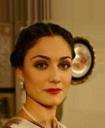
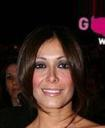
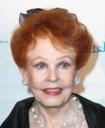
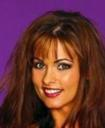
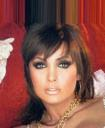
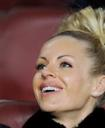
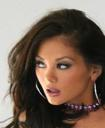
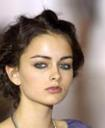
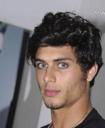
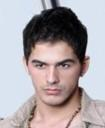
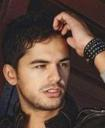
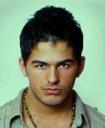
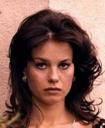
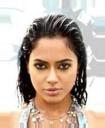
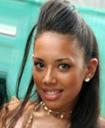
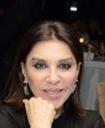
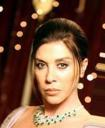
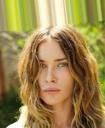
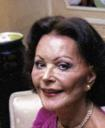
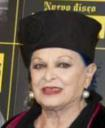
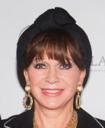
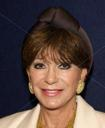
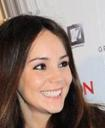
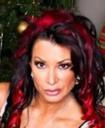
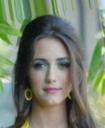
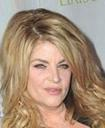
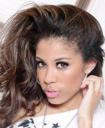
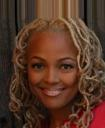
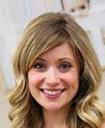
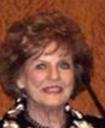

In [147]:
dp.lz[dp["clip(image)-target-probs"] == 2]